<h2> Load Library <h2>

In [33]:
import cv2
print(cv2.__version__)
import numpy as np
import sys
import os
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
print('opencv = 4.1.0')
print('keras = 2.2.4')

4.1.1
opencv = 4.1.0
keras = 2.2.4


<h2> Fungtion mengambil Gambar <h2>

<h2>1. Memasukan Nama untuk ditraining <h2>

In [34]:
nama_muka= 'ardi'
jmlh_training= 300

<h2> 2. load library haarcascade dan folder data training <h2> 

In [35]:
cascPath = "haarcascade/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(cascPath)
folder_umum = 'data_gambar_sklearn'
path = os.path.join(folder_umum, nama_muka)
if not os.path.isdir(path):
    os.mkdir(path)

count_captures = 0
count_timer = 0

<h2> 3.Display a video with Opencv dan Python <h2>

In [36]:
def ambil_gambar():
    global count_timer
    global count_captures 
    video_capture=cv2.VideoCapture(0)
    while True:
        count_timer +=1
        ret, frame = video_capture.read()
        gambar_masuk=np.array(frame)
        gambar_keluar= proses_gambar(gambar_masuk)
        cv2.imshow('video',gambar_keluar)
        if cv2.waitKey(1)&0xff==ord('q'):
            video_capture.release()
            cv2.destroyAllWindows()
            return

<h2> 3. Proses face Detection, Image Processing, dan simpan Gambar <h2>

In [37]:
def proses_gambar(gambar_masuk):
    global count_captures 
    global count_timer
    RESIZE_FACTOR = 4
    frame = cv2.flip(gambar_masuk,1)
    resized_width, resized_height = (112, 92)  
    if count_captures < jmlh_training:
        frame = frame.astype(np.uint8)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        gray_resized = cv2.resize(gray, (160, 130))        
        faces = face_cascade.detectMultiScale(
            gray_resized,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
            )
        if len(faces) > 0:
            areas = []
            for (x, y, w, h) in faces: 
                areas.append(w*h)
            max_area, idx = max([(val,idx) for idx,val in enumerate(areas)])
            face_sel = faces[idx]

            x = face_sel[0] * RESIZE_FACTOR
            y = face_sel[1] * RESIZE_FACTOR
            w = face_sel[2] * RESIZE_FACTOR
            h = face_sel[3] * RESIZE_FACTOR

            face = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (resized_width, resized_height))
            img_no = sorted([int(fn[:fn.find('.')]) for fn in os.listdir(path) if fn[0]!='.' ]+[0])[-1] + 1
            FREQ_DIV = 5
            if count_timer%FREQ_DIV == 0:
                cv2.imwrite('%s/%s.png' % (path, img_no), face_resized)
                count_captures += 1
                print ("gambar ke-: ", count_captures)

            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 3)
            cv2.putText(frame,nama_muka, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1,(0, 255, 0))
    elif count_captures == jmlh_training:
        count_captures += 1

    return frame 

<h2> End Function Take_images <h2>

<h2> Training data gambar <h2>

<h2> 1. function Training Data <h2>

In [38]:
def training_data():
    #load Folder Image.
    data_path = os.path.expanduser('data_gambar_sklearn')
    data_dir_list = sorted(os.listdir(data_path))
    
    #size Image and chanel
    img_rows=112
    img_cols=92
    num_channel=1
    
    img_data_list=[]
    labels=[]
    data_nama=[]
    index = 0
    #load Image and processing.
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        data_nama.append(dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
            img_data_list.append(input_img_resize)
            label = index
            labels.append(int(label))
        index += 1
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float64')
    img_data /= 255
    print (img_data.shape)

    if num_channel==1:
        if K.image_dim_ordering()=='th':
            img_data= np.expand_dims(img_data, axis=1) 
            print (img_data.shape)
        else:
            img_data= np.expand_dims(img_data, axis=4) 
            print (img_data.shape)

    else:
        if K.image_dim_ordering()=='th':
            img_data=np.rollaxis(img_data,3,1)
            print (img_data.shape)

    #%%
    USE_SKLEARN_PREPROCESSING=False

    if USE_SKLEARN_PREPROCESSING:
        # using sklearn for preprocessing
        from sklearn import preprocessing

        def image_to_feature_vector(image, size=(img_rows, img_cols)):
            # resize the image to a fixed size, then flatten the image into
            # a list of raw pixel intensities
            return cv2.resize(image, size).flatten()

        img_data_list=[]
        data_nama=[]    
        for dataset in data_dir_list:
            img_list=os.listdir(data_path+'/'+ dataset)
            data_nama.append(dataset)
            print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
            for img in img_list:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
                input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                input_img_flatten=image_to_feature_vector(input_img,(img_rows,img_cols))
                img_data_list.append(input_img_flatten)
                label = index
                labels.append(int(label))
            index += 1
        img_data = np.array(img_data_list)
        img_data = img_data.astype('float64')
        print (img_data.shape)
        img_data_scaled = preprocessing.scale(img_data)
        print (img_data_scaled.shape)

        print (np.mean(img_data_scaled))
        print (np.std(img_data_scaled))

        print (img_data_scaled.mean(axis=0))
        print (img_data_scaled.std(axis=0))

        if K.image_dim_ordering()=='th':
            img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
            print (img_data_scaled.shape)

        else:
            img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
            print (img_data_scaled.shape)


        if K.image_dim_ordering()=='th':
            img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
            print (img_data_scaled.shape)

        else:
            img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
            print (img_data_scaled.shape)

    if USE_SKLEARN_PREPROCESSING:
        img_data=img_data_scaled
    print(data_nama)
    
    #shape 4 dimensi to 2 dimasion
    shape = img_data.shape
    img_data1 = img_data.reshape((shape[0], shape[1] * shape[2]*shape[3]))
    img_data1.shape
    print (img_data1.shape)
    
    #shuffle
    x,y = shuffle(img_data1,labels, random_state=3)
    print(img_data.shape)
    
    # membagi the dataset
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3)
    
    #=================================LDA ======================================================
    #ekstraksi fitur LDA 
    lda = LDA(n_components=30)
    lda = lda.fit(X_train,y_train)
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)
    print (X_test_lda)
    
    #simpen Model PCD
    with open ('model/LDA_mlp.pkl', 'wb') as lda2:
        pickle.dump(lda,lda2)

    #Training using MPLClassifier LDA 
    clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_lda, y_train)
    
    #save Model MLPC LDA
    with open ('model/model_LDA_mlp.pkl', 'wb') as MLP:
        pickle.dump(clf,MLP)
    
    #prediksi LAD 
    y_pred = clf.predict(X_test_lda)
    print(y_pred)
    
    #akurasi
    akurasi=clf.score(X_test_lda, y_test) 
    print('akurasi : ', akurasi)
    
    
        #============================== PCA =================================================
##ekstraksi fitur PCA
#     n_components = 40
#     pca = PCA(n_components=n_components).fit(X_train)
#     X_train_pca = pca.transform(X_train)
#     X_test_pca = pca.transform(X_test)
    
#     #simpen Model PCA
#     with open ('model/PCA_mlp.pkl', 'wb') as pca2:
#         pickle.dump(pca,pca2)
    
        #Training using MPLClassifier PCA
#     clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_pca, y_train)
    
#     #save Model MLPC
#     with open ('model/model_PCA_mlp.pkl', 'wb') as MLP:
#         pickle.dump(clf,MLP)
    
    
    #prediksi PCA 
#     y_pred = clf.predict(X_test_pca)
#     print(y_pred)
    
#     #akurasi
#     akurasi=clf.score(X_test_pca, y_test) 
#     print('akurasi : ', akurasi)
    
    
    #mengubah nilai index ke nama foto.
    list_labels = data_nama
    def from_class_to_label(kelas):
        for i in list_labels:
            if kelas==list_labels.index(i):
                return i
    print("Fungsi berhasil di load")
    hasil_pred= []
    for i in y_pred:
        deteksi = from_class_to_label(i)
        hasil_pred.append(deteksi)
    print(hasil_pred)
    
    
    #Menampilkan Gambar dan judul (prediksi) dan eigenfaces
    _,_, h, w = img_data.shape
    
    #=====PCA============
#     eigenfaces = pca.components_.reshape((n_components, h, w))
    
#     print('hay',eigenfaces.shape[2])
    
#     def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
#         #"""Helper function to plot a gallery of portraits"""
#         plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
#         plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#         for i in range(n_row * n_col):
#             plt.subplot(n_row, n_col, i + 1)
#             plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
#             plt.title(titles[i], size=12)
#             plt.xticks(())
#             plt.yticks(())
#     def title(y_pred, y_test, list_labels, i):
#         pred_name = list_labels[y_pred[i]].rsplit(' ', 1)[-1]
#         true_name = list_labels[y_test[i]].rsplit(' ', 1)[-1]
#         return 'prediksi: %s\nAsli:      %s' % (pred_name, true_name)

#     prediction_titles = [title(y_pred, y_test, list_labels, i)
#                          for i in range(y_pred.shape[0])]

#     plot_gallery(X_test, prediction_titles, h, w)
#     eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
#     plot_gallery(eigenfaces, eigenface_titles, h, w)
    
     #=====LDA=============
    def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
        #"""Helper function to plot a gallery of portraits"""
        plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())
    def title(y_pred, y_test, list_labels, i):
        pred_name = list_labels[y_pred[i]].rsplit(' ', 1)[-1]
        true_name = list_labels[y_test[i]].rsplit(' ', 1)[-1]
        return 'prediksi: %s\nAsli:      %s' % (pred_name, true_name)

    prediction_titles = [title(y_pred, y_test, list_labels, i)
                         for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, h, w)


    plt.show()
    return ('akurasi =',akurasi*100)

Loaded the images of dataset-Nova

Loaded the images of dataset-Sean

Loaded the images of dataset-Wahyu

Loaded the images of dataset-Welly

Loaded the images of dataset-ardi

Loaded the images of dataset-eko

Loaded the images of dataset-muti

Loaded the images of dataset-unknown

(885, 92, 112)
(885, 1, 92, 112)
['Nova', 'Sean', 'Wahyu', 'Welly', 'ardi', 'eko', 'muti', 'unknown']
(885, 10304)
(885, 1, 92, 112)


C:\Users\Jamhari-Pc\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[[ 3.79081177e+01  6.91507865e+00 -7.97017415e+00 ...  4.32039022e+00
  -5.16921277e+00  5.12417261e+00]
 [-3.95718208e+00  6.31941110e+00 -8.33406869e+00 ... -6.71039188e+00
   5.79193010e+00 -1.06456090e+01]
 [ 3.65035096e+01 -1.05787723e+00 -7.62562219e+00 ...  2.45375554e-01
   1.62490514e+00 -1.48544759e-02]
 ...
 [-1.71013581e+01  6.49866017e+00  3.28720978e+00 ...  4.71329689e+00
  -9.15145434e+00 -5.02481407e+00]
 [ 3.23525332e+01  8.88355712e-01 -6.18558824e+00 ...  6.60612018e+00
  -5.09491638e+00  2.93823569e+00]
 [ 4.28920729e+01  5.64171763e+00 -1.37501609e+01 ...  4.45834396e+00
   1.68100110e+00  3.16108929e+00]]
Iteration 1, loss = 2.22125687
Validation score: 1.000000
Iteration 2, loss = 0.30508817
Validation score: 1.000000
Iteration 3, loss = 0.05868697
Validation score: 1.000000
Iteration 4, loss = 0.01351538
Validation score: 1.000000
Iteration 5, loss = 0.00450915
Validation score: 1.000000
Iteration 6, loss = 0.00200357
Validation score: 1.000000
Iteration 7, los

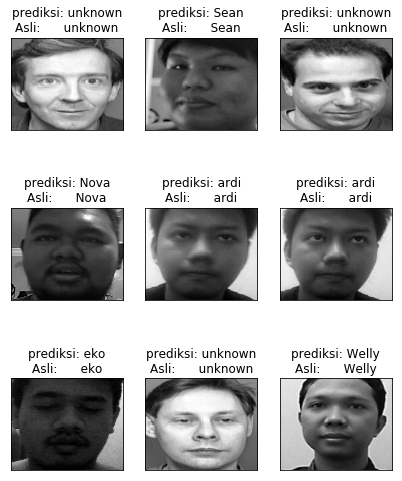

('akurasi =', 98.1981981981982)

In [39]:
#ambil_gambar()
training_data()

In [40]:
#references
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html